# Exploring a DataFrames version of the former work

## Starting PySparkSQL

This interface allows the use the tabular methods provided by DataFrames. Spark offers a DataFrame API, through their Spark SQL.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Cluster analysis") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/16 10:06:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Parsing the schema file

In [2]:
from schema import Schema
from tabulate import tabulate
from importlib import reload
from pyspark.sql import functions as F

schema = Schema("../data/schema.csv")

## Loading a CSV file

To [load a CSV as a DataFrame](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html#pyspark.sql.DataFrameReader.csv),

In [3]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType

# Mapping from field type as provided by the schema file, to their SparkSQL equivalent types
field_to_spark_type = {
    'time': LongType,
    'machine ID': LongType,
    'event type': IntegerType,
    'platform ID': StringType,
    'CPUs': FloatType,
    'Memory': FloatType
}

# Object representing the format of the data we will be loading, so SparkSQL can do the proper pre-processing
machine_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory'])
    for field in schema.get_table_schema('machine_events')['fields']
])

machine_events = spark.read \
    .format('csv') \
    .option("header","false") \
    .schema(machine_events_schema) \
    .load("../data/machine_events/part-00000-of-00001.csv")

Let us check that the schema is as we expect

In [4]:
machine_events.printSchema()

root
 |-- time: long (nullable = true)
 |-- machine_ID: long (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- platform_ID: string (nullable = true)
 |-- CPUs: float (nullable = true)
 |-- Memory: float (nullable = true)



And inspect the first few data

In [5]:
for elem in machine_events.take(5):
	print(elem.asDict())

{'time': 0, 'machine_ID': 5, 'event_type': 0, 'platform_ID': 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 'CPUs': 0.5, 'Memory': 0.2493000030517578}
{'time': 0, 'machine_ID': 6, 'event_type': 0, 'platform_ID': 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 'CPUs': 0.5, 'Memory': 0.2493000030517578}
{'time': 0, 'machine_ID': 7, 'event_type': 0, 'platform_ID': 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 'CPUs': 0.5, 'Memory': 0.2493000030517578}
{'time': 0, 'machine_ID': 10, 'event_type': 0, 'platform_ID': 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 'CPUs': 0.5, 'Memory': 0.2493000030517578}
{'time': 0, 'machine_ID': 13, 'event_type': 0, 'platform_ID': 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 'CPUs': 0.5, 'Memory': 0.2493000030517578}


How much events do we have?

In [6]:
machine_events.count(), machine_events.filter(machine_events.event_type == 1).count(),machine_events.filter(machine_events.event_type == 2).count()

(37780, 8957, 7380)

In [7]:
creation_events = machine_events.filter(machine_events.event_type == 0)

cpu_counts = creation_events.groupBy("CPUs").count()
cpu_counts.show()

+----+-----+
|CPUs|count|
+----+-----+
|0.25|  224|
|null|   32|
| 0.5|19773|
| 1.0| 1414|
+----+-----+



Just because we can, here is a version in SQL:

In [8]:
creation_events.createOrReplaceTempView("creation_events")

spark.sql("SELECT CPUs, COUNT(*) "
           "FROM creation_events "
           "GROUP BY CPUs;").show()

+----+--------+
|CPUs|count(1)|
+----+--------+
|0.25|     224|
|null|      32|
| 0.5|   19773|
| 1.0|    1414|
+----+--------+



## Percentage of lost computational power

In [9]:
machine_events.createOrReplaceTempView("machine_events")

In [10]:
bad_cpu_machines = spark.sql("SELECT DISTINCT machine_ID "
                             "FROM machine_events "
                             "WHERE CPUs IS NULL")
bad_cpu_machines.count()

32

In [11]:
spark.sql(
    "SELECT * FROM machine_events "
    "WHERE CPUs IS NOT NULL "
    # "GROUP BY machine_ID "
    "ORDER BY time "
    ).show()

+----+----------+----------+--------------------+----+------+
|time|machine_ID|event_type|         platform_ID|CPUs|Memory|
+----+----------+----------+--------------------+----+------+
|   0|         5|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|         6|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|         7|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        10|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        13|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        14|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        19|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        21|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        23|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        25|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        26|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        27|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|        28|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|  

Let us check the maximum number of events associated with any machine:

In [12]:
spark.sql(
    "SELECT COUNT(*) as n_events FROM machine_events "
    "WHERE CPUs IS NOT NULL "
    "GROUP BY machine_ID "
    "ORDER BY n_events DESC "
    "LIMIT 1"
    ).show()

+--------+
|n_events|
+--------+
|     330|
+--------+



We have here 330 events at most for a machine. It should be easily managable by regular python code so we can proceed with the approach below.

In [13]:
grouped_machine_events = machine_events \
    .filter(machine_events['CPUs'].isNotNull()) \
    .orderBy(machine_events['time']) \
    .groupBy(machine_events['machine_ID']) \
    .agg(
        F.collect_list('time').alias('time'),
        F.collect_list('event_type').alias('event_type'),
        F.collect_list('CPUs').alias('CPUs'))

In [14]:
grouped_machine_events.show()

+----------+--------------------+--------------------+--------------------+
|machine_ID|                time|          event_type|                CPUs|
+----------+--------------------+--------------------+--------------------+
|         5|[835150655707, 83...|           [1, 0, 0]|     [0.5, 0.5, 0.5]|
|         6|                 [0]|                 [0]|               [0.5]|
|         7|                 [0]|                 [0]|               [0.5]|
|        10|[1306164355566, 1...|           [1, 0, 0]|     [0.5, 0.5, 0.5]|
|        13|[2447693838527, 2...|           [1, 0, 0]|     [0.5, 0.5, 0.5]|
|        14|                 [0]|                 [0]|               [0.5]|
|        19|                 [0]|                 [0]|               [0.5]|
|        21|[1973117638055, 1...|        [2, 2, 2, 0]|[0.5, 0.5, 0.5, 0.5]|
|        23|[481673206369, 48...|     [2, 2, 1, 0, 0]|[0.5, 0.5, 0.5, 0...|
|        25|[669036455186, 68...|[2, 2, 2, 2, 2, 2...|[0.5, 0.5, 0.5, 0...|
|        26|

In [15]:
from pyspark.sql import Column

def col_gen(df):
    print(len(F.array(df.time)))
    # accumulateur = df.machine_ID * 0
    # for t in  df.time:
    #     accumulateur += t
    return df.time

grouped_machine_events.withColumn('aggrégée', col_gen(grouped_machine_events)).show()

TypeError: object of type 'Column' has no len()

In [ ]:
from pyspark.sql.functions import pandas_udf

def filter_func(iterator):
    for pdf in iterator:
        print(type(pdf))
        yield pdf

grouped_machine_events.mapInPandas(filter_func, grouped_machine_events.schema).show()

In [ ]:
def my_function(df):
    df.time[0]+1

grouped_machine_events.to_pandas_on_spark().apply(my_function)

In [ ]:
import pandas as pd
from pyspark.sql.functions import pandas_udf

In [ ]:
event_mapping = {0: 'add', 1: 'remove', 2: 'update'}

@pandas_udf("cpu double")
def lost_and_total_power(time: pd.Series, event_type: pd.Series, CPUs: pd.Series) -> tuple[float, float]:
    return CPUs[-1]
    min_cpu = float('inf')
    max_cpu = float('-inf')
    for i, ev in events.items():
        # event_to_accumulator(event)
        # update_accumulator(event)
        if ev['CPUs'] < min_cpu:
            min_cpu = ev['CPUs']
        if ev['CPUs'] > max_cpu:
            max_cpu = ev['CPUs']
    return pd.DataFrame({'min cpu': min_cpu, 'max cpu': max_cpu})


grouped_machine_events \
    .agg(
        lost_and_total_power(
            machine_events['time'],
            machine_events['event_type'],
            machine_events['CPUs'])) \
    .show()

This route seams to be a dead end. The `applyInPandas` method on grouped data seems to not allow for iterative code. How can I do this aggregation then ?

Based on the documentation[[1]](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.pandas_udf.html#pyspark.sql.functions.pandas_udf)[[2]](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.applyInPandas.html#pyspark.sql.GroupedData.applyInPandas) and our experiments, it seems infeasible to use the grouped data to compute the lost computational power.

## In general, do tasks from the same job run on the same machine?

In [16]:
# Mapping from field type as provided by the schema file, to their SparkSQL equivalent types
from pyspark.sql.types import BooleanType

field_to_spark_type = {
    'time': LongType,
    'missing info': LongType,
    'job ID': LongType,
    'task index': IntegerType,
    'machine ID': LongType,
    'event type': IntegerType,
    'user': StringType,
    'scheduling class': IntegerType,
    'priority': IntegerType,
    'CPU request': FloatType,
    'memory request': FloatType,
    'disk space request': FloatType,
    'different machines restriction': BooleanType
}

# Object representing the format of the data we will be loading, so SparkSQL can do the proper pre-processing
task_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory'])
    for field in schema.get_table_schema('task_events')['fields']
])

task_events = spark.read \
    .format('csv') \
    .option("header","false") \
    .schema(task_events_schema) \
    .load("../data/task_events")

In [17]:
task_events.show()

+-----------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|       time|missing_info|    job_ID|task_index|machine_ID|event_type|                user|scheduling_class|priority|CPU_request|memory_request|disk_space_request|different_machines_restriction|
+-----------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|95813803204|        null|6238340468|      2025| 317469463|         2|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          null|
|95813803212|        null|6238340468|      2025|      null|         0|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          null|
|95813803214|        null

We note from the above display and the schema file that the attribute *machine_ID* can be *null*, as such, we need to filter it out before other operations.

In [20]:
different_machines_histogram = task_events.filter(task_events.machine_ID.isNotNull())\
    .groupBy("job_ID") \
    .agg(F.count_distinct(task_events.machine_ID)) \
    .groupBy("count(machine_ID)") \
    .agg({"job_ID":"count"}) \
    .orderBy("count(machine_ID)") \
    .withColumnRenamed("count(machine_ID)","nb_machine") \
    .withColumnRenamed("count(job_ID)","count") \
    .cache()

different_machines_histogram.show()


+----------+-----+
|nb_machine|count|
+----------+-----+
|         1|37656|
|         2| 3228|
|         3|  665|
|         4|  296|
|         5|  407|
|         6|  407|
|         7|  199|
|         8|  158|
|         9|  472|
|        10|  235|
|        11|  848|
|        12|  152|
|        13|   85|
|        14|  324|
|        15| 1031|
|        16|  231|
|        17|   79|
|        18|  107|
|        19|   45|
|        20|  110|
+----------+-----+
only showing top 20 rows



In [28]:
import matplotlib.pyplot as plt

iterator = different_machines_histogram.toLocalIterator()
X = []
Y = []

for row in iterator:
    d = row.asDict()
    X += [d["nb_machine"]]
    Y += [d["count"]]
    

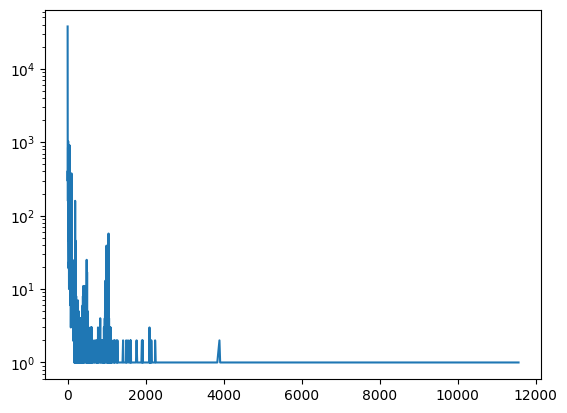

In [30]:
plt.plot(X,Y)
plt.yscale("log")
plt.show()